In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

In [2]:
class MLP(nn.Module):
    def __init__(self, input_size, h1, h2, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, h1)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(h1, h2)
        self.fc3 = nn.Linear(h2, output_size)
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        return out

In [3]:
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        sample = {
            'data': torch.FloatTensor(self.data[idx]),
            'label': torch.FloatTensor([self.labels[idx]])
        }
        return sample

In [4]:
data = pd.read_csv('../ea-based-nn-ik-solver/datasets/6DoF-6R-Puma260/data_3DoF-3R.csv')
data = np.array(data).astype(np.float32)
joints = data[:,-3:]
pos = data[:,:-3]

In [5]:
pos.dtype

dtype('float32')

In [6]:
X_train, X_test, y_train, y_test = train_test_split(joints, pos, test_size=0.2, random_state=42)

In [7]:
train_dataset = CustomDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


In [8]:
test_dataset = CustomDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [68]:
input_size = joints.shape[1]
h1 = 64
h2 = 128
output_size = pos.shape[1]
learning_rate = 0.0001
num_epochs = 100

In [69]:
model = MLP(input_size, h1, h2, output_size)
criterion = nn.MSELoss()
test_criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [70]:

# Training loop
for epoch in range(num_epochs):
    for batch in train_loader:
        inputs = batch['data']
        labels = batch['label'].squeeze()
        
        # Forward pass
        outputs = model(inputs)
        loss = test_criterion(outputs, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Testing the model
model.eval()
correct = 0
total = 0
mean_loss = []
with torch.no_grad():
    for batch in test_loader:
        inputs = batch['data']
        labels = batch['label'].squeeze()
        outputs = model(inputs)
#         _, predicted = torch.max(outputs.data, 1)
        loss = test_criterion(outputs, labels)
        mean_loss.append(loss.item())
#         correct += (predicted == labels).sum().item()
mean_loss = np.mean(np.array(mean_loss))
print(f'Test Error: {mean_loss}')

Epoch [1/100], Loss: 0.5162
Epoch [2/100], Loss: 0.4383
Epoch [3/100], Loss: 0.4036
Epoch [4/100], Loss: 0.2905
Epoch [5/100], Loss: 0.2804
Epoch [6/100], Loss: 0.1706
Epoch [7/100], Loss: 0.1836
Epoch [8/100], Loss: 0.1569
Epoch [9/100], Loss: 0.1125
Epoch [10/100], Loss: 0.0725
Epoch [11/100], Loss: 0.0911
Epoch [12/100], Loss: 0.0486
Epoch [13/100], Loss: 0.0745
Epoch [14/100], Loss: 0.0922
Epoch [15/100], Loss: 0.0485
Epoch [16/100], Loss: 0.0362
Epoch [17/100], Loss: 0.0434
Epoch [18/100], Loss: 0.0673
Epoch [19/100], Loss: 0.0501
Epoch [20/100], Loss: 0.0271
Epoch [21/100], Loss: 0.0367
Epoch [22/100], Loss: 0.0218
Epoch [23/100], Loss: 0.0233
Epoch [24/100], Loss: 0.0376
Epoch [25/100], Loss: 0.0239
Epoch [26/100], Loss: 0.0322
Epoch [27/100], Loss: 0.0347
Epoch [28/100], Loss: 0.0392
Epoch [29/100], Loss: 0.0229
Epoch [30/100], Loss: 0.0213
Epoch [31/100], Loss: 0.0276
Epoch [32/100], Loss: 0.0275
Epoch [33/100], Loss: 0.0281
Epoch [34/100], Loss: 0.0173
Epoch [35/100], Loss: 0

In [10]:

# Define the two MLP networks
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MLP, self).__init__()
        layers = []
        for i in range(len(hidden_sizes)):
            if i == 0:
                layers.append(nn.Linear(input_size, hidden_sizes[i]))
            else:
                layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_sizes[-1], output_size))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

# Define the main network that combines the two MLPs
class MyNetwork(nn.Module):
    def __init__(self, input_size, middle_state_size, output_size, second_network_path=None):
        super(MyNetwork, self).__init__()
        # The first MLP maps inputs to middle states
        self.mlp1 = MLP(input_size, [64, 128], middle_state_size)  # Example hidden sizes

        # The second MLP maps middle states to outputs
        self.mlp2 = MLP(middle_state_size, [128, 64], output_size)  # Example hidden sizes

        # Load the second network weights if provided
        if second_network_path:
            self.mlp2.load_state_dict(torch.load(second_network_path))
            # Freeze the second network
            for param in self.mlp2.parameters():
                param.requires_grad = False

    def forward(self, x):
        middle_state = self.mlp1(x)
        output = self.mlp2(middle_state)
        return output

# Example usage
# input_size = 10
# middle_state_size = 20
# output_size = 10
# second_network_path = 'path_to_second_network.pth'  # Replace with actual path

# # Initialize the network
# my_network = MyNetwork(input_size, middle_state_size, output_size, second_network_path)


In [11]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MLP, self).__init__()
        layers = []
        for i in range(len(hidden_sizes)):
            if i == 0:
                layers.append(nn.Linear(input_size, hidden_sizes[i]))
            else:
                layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_sizes[-1], output_size))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

In [36]:
input_size = joints.shape[1]
hidden_sizes = [64, 128]
output_size = pos.shape[1]
learning_rate = 0.0001
num_epochs = 100

model = MLP(input_size, hidden_sizes, output_size)
criterion = nn.MSELoss()
test_criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [25]:
# device = torch.device('cuda')

False

# Jacobians

In [18]:
def get_network_jacobian(self, inputs, output_poses):
    # compute the Jacobian
    batch = inputs.shape[0]
    input_size = inputs.shape[1]
    output_size = self.output_dim #* self.dim_position

    # initialize a tensor to hold the Jacobian
    J = torch.zeros(batch, 1 , input_size, output_size)
    #print('J: ', J.shape)
    #print('output_size: ', output_size)
    #print('output_poses: ', output_poses.shape)
    #print('inputs: ', inputs.shape)

    t = time.time()
    for j in range(output_size):
        g = torch.autograd.grad(output_poses[:,j], 
                                inputs, 
                                grad_outputs=torch.ones_like(output_poses[:,j]),
                                retain_graph=True)
        g = g[0].permute(1,0)
        g = torch.reshape(g, (batch, 1, input_size))
        J[:,:,:,j] = g
        #print('g{}: {}'.format(j, g))
    #print('g: ', g.shape)
    #print('J: ', J.shape)
    J_reshape = torch.reshape(J, (batch, -1, self.input_dim))
    #print(J[0,:,:,0])
    #print(J[0,:,:,1])
    #print(J_reshape[0,:,:])
    #print('J_reshape: ', J_reshape.shape)

    J_reshape = J_reshape.permute(0, 2, 1) 
    #print('J_reshape: ', J_reshape.shape)
    #print(J_reshape[0,:,:])
    return J_reshape

In [19]:
def combined_loss(output_poses, target_poses, J_predicted, J_target, lambda_val):
    position_loss = torch.nn.functional.mse_loss(output_poses, target_poses)
    jacobian_loss = torch.nn.functional.mse_loss(J_predicted, J_target)
    return position_loss + lambda_val * jacobian_loss

In [37]:
training_total_loss = []
# Training loop
for epoch in range(num_epochs):
    for batch in train_loader:
        inputs = batch['data']
        labels = batch['label'].squeeze()
        
        # Forward pass
        outputs = model(inputs)
#         J_predicted = model.get_network_jacobian(inputs, outputs)
        
        loss = test_criterion(outputs, labels)
#         loss = combined_loss(output_poses, target_poses, J_predicted, target_jacobians, lambda_val=0.1)

        training_total_loss.append(loss.item())
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Testing the model
model.eval()
correct = 0
total = 0
total_loss = []
with torch.no_grad():
    for batch in test_loader:
        inputs = batch['data']
        labels = batch['label'].squeeze()
        outputs = model(inputs)
#         _, predicted = torch.max(outputs.data, 1)
        loss = test_criterion(outputs, labels)
        total_loss.append(loss.item())
#         correct += (predicted == labels).sum().item()
mean_loss = np.mean(np.array(total_loss))
std_loss = np.std(np.array(total_loss))
print(f'mean Test Error: {mean_loss}')
print(f'Std Test Error: {std_loss}')

Epoch [1/100], Loss: 0.5375
Epoch [2/100], Loss: 0.3687
Epoch [3/100], Loss: 0.3703
Epoch [4/100], Loss: 0.2877
Epoch [5/100], Loss: 0.2072
Epoch [6/100], Loss: 0.2074
Epoch [7/100], Loss: 0.1280
Epoch [8/100], Loss: 0.1038
Epoch [9/100], Loss: 0.1017
Epoch [10/100], Loss: 0.0598
Epoch [11/100], Loss: 0.0588
Epoch [12/100], Loss: 0.0659
Epoch [13/100], Loss: 0.0632
Epoch [14/100], Loss: 0.0488
Epoch [15/100], Loss: 0.0522
Epoch [16/100], Loss: 0.0505
Epoch [17/100], Loss: 0.0413
Epoch [18/100], Loss: 0.0344
Epoch [19/100], Loss: 0.0538
Epoch [20/100], Loss: 0.0233
Epoch [21/100], Loss: 0.0327
Epoch [22/100], Loss: 0.0455
Epoch [23/100], Loss: 0.0233
Epoch [24/100], Loss: 0.0265
Epoch [25/100], Loss: 0.0229
Epoch [26/100], Loss: 0.0264
Epoch [27/100], Loss: 0.0255
Epoch [28/100], Loss: 0.0193
Epoch [29/100], Loss: 0.0323
Epoch [30/100], Loss: 0.0224
Epoch [31/100], Loss: 0.0278
Epoch [32/100], Loss: 0.0289
Epoch [33/100], Loss: 0.0201
Epoch [34/100], Loss: 0.0200
Epoch [35/100], Loss: 0

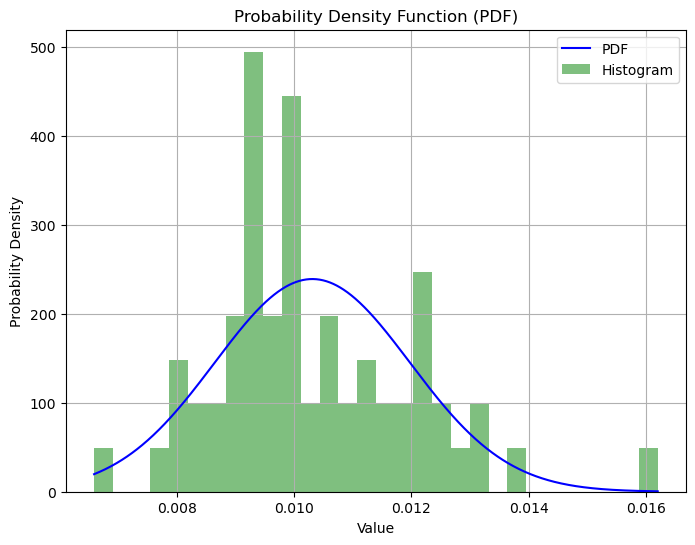

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

data = np.array(total_loss)

kde = norm(loc=np.mean(data), scale=np.std(data))
x_values = np.linspace(min(data), max(data), 1000)
pdf_values = kde.pdf(x_values)

plt.figure(figsize=(8, 6))
plt.plot(x_values, pdf_values, label='PDF', color='blue')
plt.hist(data, bins=30, density=True, alpha=0.5, color='green', label='Histogram')  # Overlay a histogram for comparison
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.title('Probability Density Function (PDF)')
plt.legend()
plt.grid(True)
plt.show()

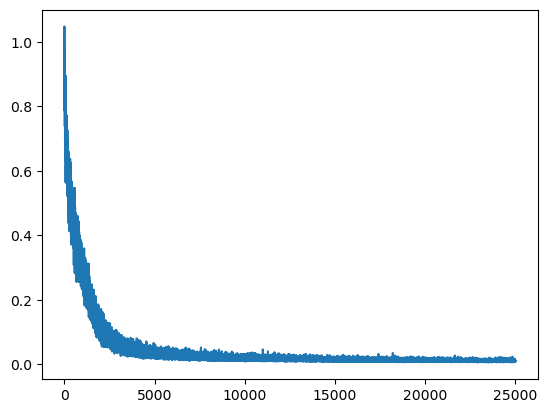

In [38]:
plt.plot(np.array(training_total_loss))

In [75]:
model_weights_path = './model_weights/test_1.pth'

# Save the model's state_dict to the specified path
torch.save(model.state_dict(), model_weights_path)

In [80]:
# Define the main network that combines the two MLPs
class IK_Network(nn.Module):
    def __init__(self, input_size, middle_state_size, output_size, second_network_path=None):
        super(IK_Network, self).__init__()
        # The first MLP maps inputs to middle states
        self.mlp1 = MLP(input_size, [64, 128], middle_state_size)  # Example hidden sizes

        # The second MLP maps middle states to outputs
        self.mlp2 = MLP(middle_state_size, [64, 128], output_size)  # Example hidden sizes

        # Load the second network weights if provided
        if second_network_path:
            self.mlp2.load_state_dict(torch.load(second_network_path))
            # Freeze the second network
            for param in self.mlp2.parameters():
                param.requires_grad = False

    def forward(self, x):
        middle_state = self.mlp1(x)
        output = self.mlp2(middle_state)
        return output

In [81]:
# Example usage
input_size = pos.shape[1]
middle_state_size = joints.shape[1]
output_size = pos.shape[1]
second_network_path = './model_weights/test_1.pth'  # Replace with actual path

# Initialize the network
my_network = IK_Network(input_size, middle_state_size, output_size, second_network_path)

In [1]:
from model import *

In [2]:
from data_loading import *

In [3]:
robot_choice = "3DoF-3R"
mode_choice = "FK"
test_size = 0.2
batch_size = 32
FK_train_loader, FK_test_loader, input_size, output_size = data_loader(robot_choice, mode_choice, test_size, batch_size)

In [4]:
input_size = input_size
hidden_sizes = [64, 128]
output_size = output_size
learning_rate = 0.0001
num_epochs = 100

model = MLP(input_size, hidden_sizes, output_size)
criterion = nn.MSELoss()
test_criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [6]:

# Training loop
for epoch in range(num_epochs):
    for batch in FK_train_loader:
        inputs = batch['data']
        labels = batch['targets'].squeeze()
        
        # Forward pass
        outputs = model(inputs)
        loss = test_criterion(outputs, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Testing the model
model.eval()
correct = 0
total = 0
mean_loss = []
with torch.no_grad():
    for batch in FK_test_loader:
        inputs = batch['data']
        labels = batch['targets'].squeeze()
        outputs = model(inputs)
#         _, predicted = torch.max(outputs.data, 1)
        loss = test_criterion(outputs, labels)
        mean_loss.append(loss.item())
#         correct += (predicted == labels).sum().item()
mean_loss = np.mean(np.array(mean_loss))
print(f'Test Error: {mean_loss}')

Epoch [1/100], Loss: 0.5458
Epoch [2/100], Loss: 0.4456
Epoch [3/100], Loss: 0.3679
Epoch [4/100], Loss: 0.3171
Epoch [5/100], Loss: 0.2665
Epoch [6/100], Loss: 0.2131
Epoch [7/100], Loss: 0.1704
Epoch [8/100], Loss: 0.1410
Epoch [9/100], Loss: 0.1175
Epoch [10/100], Loss: 0.1045
Epoch [11/100], Loss: 0.0934
Epoch [12/100], Loss: 0.0809
Epoch [13/100], Loss: 0.0721
Epoch [14/100], Loss: 0.0638
Epoch [15/100], Loss: 0.0568
Epoch [16/100], Loss: 0.0517
Epoch [17/100], Loss: 0.0478
Epoch [18/100], Loss: 0.0452
Epoch [19/100], Loss: 0.0423
Epoch [20/100], Loss: 0.0404
Epoch [21/100], Loss: 0.0378
Epoch [22/100], Loss: 0.0357
Epoch [23/100], Loss: 0.0344
Epoch [24/100], Loss: 0.0335
Epoch [25/100], Loss: 0.0333
Epoch [26/100], Loss: 0.0312
Epoch [27/100], Loss: 0.0297
Epoch [28/100], Loss: 0.0286
Epoch [29/100], Loss: 0.0280
Epoch [30/100], Loss: 0.0274
Epoch [31/100], Loss: 0.0273
Epoch [32/100], Loss: 0.0270
Epoch [33/100], Loss: 0.0266
Epoch [34/100], Loss: 0.0261
Epoch [35/100], Loss: 0